In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import layers, losses
from sklearn.model_selection import train_test_split
from keras.models import Model

import warnings
warnings.filterwarnings('ignore')


2023-10-11 14:30:29.829866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-11 14:30:29.829892: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<AxesSubplot:xlabel='round', ylabel='loss'>

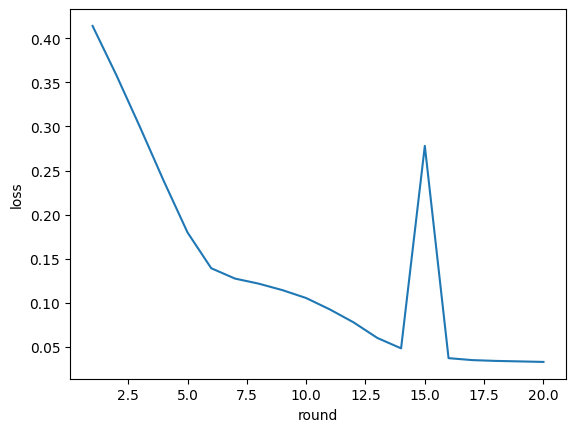

In [2]:
data = pd.read_csv('./logs/bearing/LSTM/w_anomaly/loss.csv', names = ['cid', 'round', 'loss'])
sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')

<AxesSubplot:xlabel='round', ylabel='loss'>

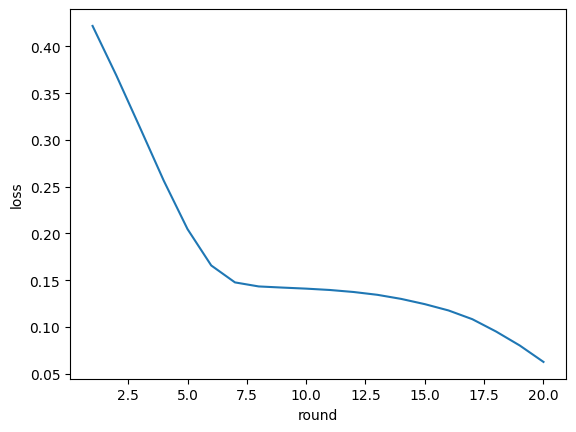

In [3]:
data = pd.read_csv('./loss.csv', names = ['cid', 'round', 'loss'])
sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')

<AxesSubplot:xlabel='round', ylabel='loss'>

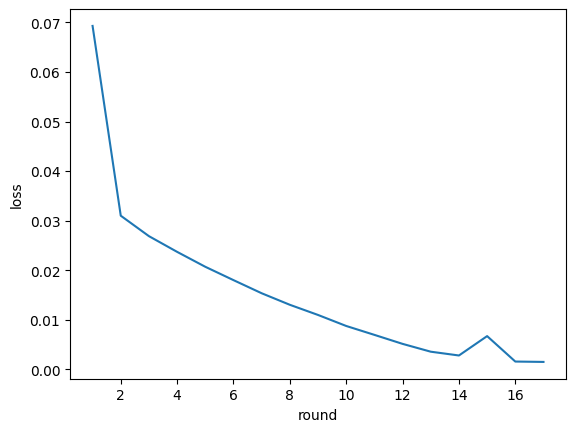

In [4]:

data = pd.read_csv('./logs/bearing/LSTM/loss.csv', names = ['cid', 'round', 'loss'])
sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')

<AxesSubplot:xlabel='round', ylabel='loss'>

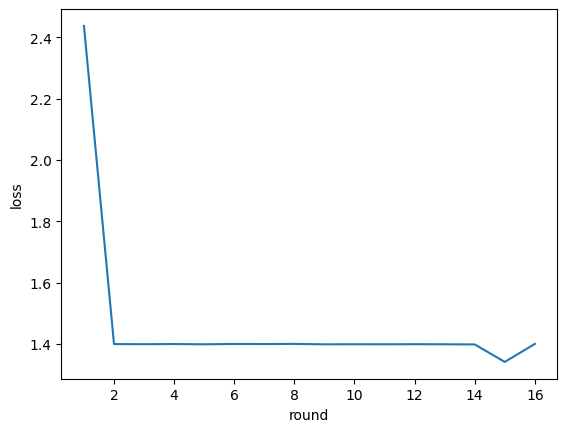

In [6]:
data = pd.read_csv('/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/LSTM/loss.csv', names = ['cid', 'round', 'loss'])
sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')